In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')
import xgboost as xgb
import pandas as pd
from features.UserJoin import UserJoin
from features.UserJoin import submit, diff, plt_month, plt_day, load_ids, diff_set
import config as C
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.metrics import f1_score
from pathlib import Path

/opt/conda/envs/miner/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# data
ds = UserJoin()

In [106]:
# t = pd.read_csv('submit_csv/label.csv')
# true_ids = set(t[t.label == 1].id.unique())
true_ids = {179458306,
            179569820,
            1606708811,
            2071313507,
            2186749200,
            2212416005,
            2256064355,
            2347718610,
            2427050072,
            2576321385}

# false_ids = {179458306,
#             179569820,
#             1606708811,
#             2071313507,
#             2186749200,
#             2212416005,
#             2256064355,
#             2347718610,
#             2427050072}

# 就先直接研究 32_27 了！

In [34]:
def infot(target):
    for i in Path('submit_csv').glob('3_10_base*.csv'):
        cmp = load_ids(i.name)
        print(i.name, target - cmp, len(target & cmp))

def info(f):
    print(f)
    target = load_ids(f)
    infot(target)
    
def except_known(f):
    ids = load_ids(f)
    true_num = int(f.split('_')[-1].replace('.csv', ''))
    t = pd.read_csv('submit_csv/label.csv')
    true_ids = set(t[t.label == 1].id.unique())
    false_ids = set(t[t.label == 0].id.unique())
    print('已知 label=1', ids & true_ids)
    print('已知 label=0', ids & false_ids)
    return ids - true_ids - false_ids, true_num-len(ids & true_ids)

target, true_num = except_known('3_10_base_32_27.csv')
print('\n', target)
print(f'total {len(target)}, true {true_num}')

已知 label=1 {179458306, 2256064355, 2071313507, 2212416005, 1606708811, 2186749200, 2347718610, 2427050072, 179569820}
已知 label=0 set()

 {2496032641, 2479963778, 2817362052, 2741872006, 2251440776, 2825175309, 2445049876, 2319973783, 2451165982, 2852503463, 2172970175, 855996491, 2238809293, 2759232590, 2347718608, 2523401557, 2533183958, 2535198432, 2471562086, 2576321385, 2717225077, 1916407803, 2717225084}
total 23, true 18


In [21]:
df = pd.read_csv('submit_csv/3_10_base_32_27.csv')
df = df[df.id.isin(target)]
df = df.set_index('id')
df = df.sort_index()

# 先观察和其他数据的交集，交集部分是1的概率大

In [44]:
infot(set(df.index.unique().values))

3_10_base_98_33.csv set() 23
3_10_base_32_27.csv set() 23
3_10_base_175_34.csv set() 23
3_10_base_544_35.csv set() 23
3_10_base_63_29.csv {2576321385, 2717225084} 21
3_10_base_34_27.csv {2852503463, 2825175309, 2533183958, 2319973783, 2717225084} 18
3_10_base_35_27.csv {2576321385, 1916407803, 2817362052} 20
3_10_base_32_24.csv {2817362052, 2741872006, 2238809293, 2825175309, 2319973783} 18


In [92]:
# 先试这10个。看里边是不是包括了要找的5个
a = [2576321385, 2717225084, 2852503463, 2825175309, 2533183958, 2319973783, 2717225084, 2576321385, 1916407803, 2817362052, 2817362052, 2741872006, 2238809293, 2825175309, 2319973783, ]
print(len(a), len(set(a)))
submit(set(a), 'submit_3_11_1.csv')

15 10
10


,id,label
0,179406029,0
1,179406030,0
2,179406094,0
3,179406097,0
4,179406099,0
...,...,...
15374,2849971818,0
15375,2850017469,0
15376,2850017472,0
15377,2851323065,0


In [93]:
r_10_1 = set(a)

## 以为能找到10个，结果只找到1个
试试看曲线，选几个出来碰那1个

In [66]:
# plt_day(a, df=ds.day)
# plt_day(a, df=ds.day, cols=['kwh'])
# plt_month(a, df=ds.month)

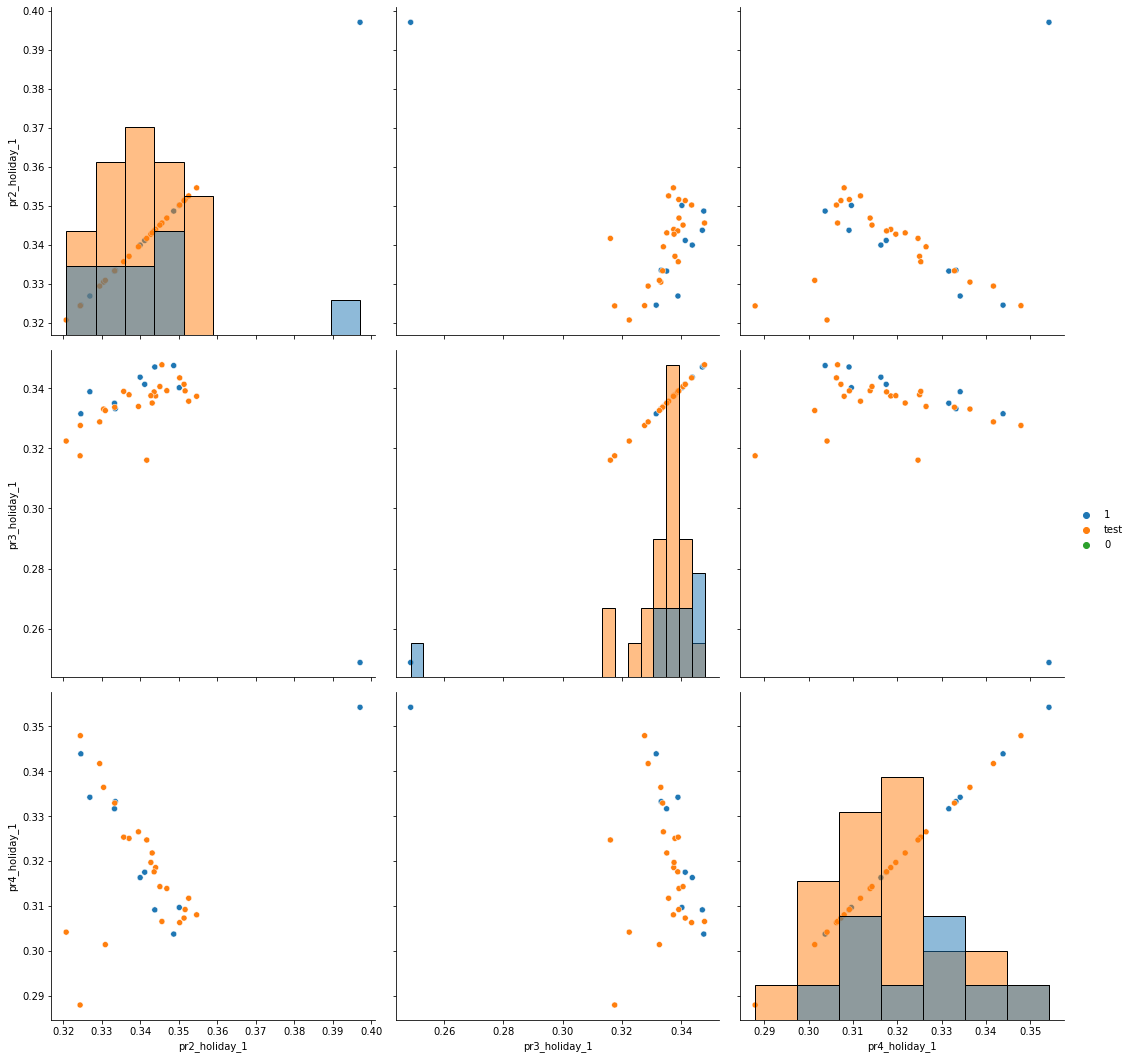

In [60]:
import seaborn as sns
cols = [
    'label',
    'pr2_holiday_1',
    'pr3_holiday_1',
    'pr4_holiday_1',
    # 'pr2_holiday_0',
    # 'pr3_holiday_0',
    # 'pr4_holiday_0',
    #     'kwh_pap_r3_holiday_0',
    #     'kwh_pap_r2_holiday_0',
    #     'kwh_pap_r3',
        # 'kwh_pap_r2',
        # 'kwh_cal_holiday_0',
        # 'kwh_holiday_0',
        # 'kwh_pap_r2_holiday_1',
        # 'kwh_pap_r3_holiday_1',
        # 'kwh',
    #     'kwh_cal_holiday_1',
    #     'kwh_holiday_1',
    # 'pr4_holiday_0',
    # 'kwh_pap_r4',
    # 'pr4_holiday_1',
]

# t = ds.train[ds.train.index.isin(a + C.minerids)]
t = ds.train[ds.train.index.isin(list(df.index.unique().values) + C.minerids)]


t = t[cols]

g = sns.PairGrid(t, height=5, hue='label', hue_order=['1', 'test', '0'])
g.map_diag(sns.histplot)
g.map(sns.scatterplot)
g.add_legend(title="", adjust_subtitles=True)

In [63]:
t[(t.pr2_holiday_1 < .34) & (t.pr4_holiday_1 < .31)]

,label,pr2_holiday_1,pr3_holiday_1,pr4_holiday_1
id,,,,
2347718608,test,0.320751,0.322457,0.304161
2451165982,test,0.324365,0.317535,0.287924
2576321385,test,0.330909,0.332620,0.301383


## 刚10个里的一个，怀疑是 2576321385 。 正好把这个 2576321385 以及其他两个。再找几个，凑一个找5个的集合。

In [ ]:
# (t.pr2_holiday_1 < .34) & (t.pr4_holiday_1 < .31)
s1 = [2451165982, 2576321385, 2347718608]

In [77]:
ds.train2.columns

Index(['ELEC_TYPE_NAME', 'VOLT_NAME', 'RUN_CAP', 'label', 'kwh', 'kwh_cal',
       'kwh_pap_r2', 'kwh_pap_r3', 'kwh_pap_r4', 'pr2', 'pr3', 'pr4', '2_3',
       '2_4', '3_4', 'daycv', 'kwh_holiday_1', 'kwh_cal_holiday_1',
       'kwh_pap_r2_holiday_1', 'kwh_pap_r3_holiday_1', 'kwh_pap_r4_holiday_1',
       'pr2_holiday_1', 'pr3_holiday_1', 'pr4_holiday_1', '2_3_holiday_1',
       '2_4_holiday_1', '3_4_holiday_1', 'daycv_holiday_1', 'kwh_holiday_0',
       'kwh_cal_holiday_0', 'kwh_pap_r2_holiday_0', 'kwh_pap_r3_holiday_0',
       'kwh_pap_r4_holiday_0', 'pr2_holiday_0', 'pr3_holiday_0',
       'pr4_holiday_0', '2_3_holiday_0', '2_4_holiday_0', '3_4_holiday_0',
       'daycv_holiday_0', 'kwh_holiday_diff', 'kwh_cal_holiday_diff',
       'kwh_pap_r2_holiday_diff', 'kwh_pap_r3_holiday_diff',
       'kwh_pap_r4_holiday_diff', 'pr2_holiday_diff', 'pr3_holiday_diff',
       'pr4_holiday_diff', '2_3_holiday_diff', '2_4_holiday_diff',
       '3_4_holiday_diff', 'daycv_holiday_diff', 'pq_f', 'pq

In [91]:
from sklearn.manifold import TSNE
t = ds.train[ds.train.index.isin(list(df.index.unique().values) + C.minerids)]
cols = ['pr2_holiday_1',
        'pr3_holiday_1',
        'pr4_holiday_1',
        'pr2_holiday_0',
        'pr3_holiday_0',
        'pr4_holiday_0', 
        'pp','pg','pf',  'pr2', 'pr3', 'pr4',
        'monthcv','daycv'
        ]
xy = TSNE(init='pca').fit_transform(t[cols])
tsne = pd.DataFrame({'x':xy[:,0], 'y': xy[:,1], 'label': t.label})
fig = px.scatter(tsne, x='x', y='y', color='label')
fig.show()

/opt/conda/envs/miner/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/opt/conda/envs/miner/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [82]:
t[(t.pq_z > 15e3)]
# s1 = [2451165982, 2576321385, 2347718608]

,label,pp,pg,pf,pq_z,monthcv
id,,,,,,
855996491,test,0.338715,0.324865,0.336420,15765.857143,0.022772
2535198432,test,0.346069,0.303258,0.350673,17293.428571,0.079201
2471562086,test,0.341641,0.310631,0.347728,20197.714286,0.062868
2717225084,test,0.342897,0.303822,0.353281,23966.190476,0.086013
2852503463,test,0.338726,0.305757,0.355517,26973.428571,0.076825
2172970175,test,0.335314,0.325764,0.338922,17407.952381,0.034218


不好找。就先按 pq_z 大的，然后前边过滤出来的3个试试把。

In [95]:
s1 = [2451165982, 2576321385, 2347718608]

s2 = [855996491, 2535198432, 2471562086, 2717225084, 2852503463, 2172970175]


print(r_10_1 & set(s2))
print(r_10_1 & set(s1))

{2717225084, 2852503463}
{2576321385}


In [99]:
r_9_4 = load_ids('submit_3_10_2.csv')
print(r_9_4 & r_10_1)

print(r_9_4 & set(df.index.unique().values))

{2576321385, 2717225084}
{2471562086, 2251440776, 2576321385, 855996491, 2717225084}


In [105]:
# 不管了。赌一下。 
print(len(true_ids | {2576321385}))
submit({2576321385} | true_ids, 'submit_3_11_2.csv')


# 赌错了。。。再也不分析了

10
10


,id,label
0,179406029,0
1,179406030,0
2,179406094,0
3,179406097,0
4,179406099,0
...,...,...
15374,2849971818,0
15375,2850017469,0
15376,2850017472,0
15377,2851323065,0


# 有个9_4的，去掉一个刚试出来的，还有8_4。 正好有4个和 df 交集是4.   这4其中1个在 r_10_1里，另外3个在  r_13_4 里

In [110]:
print({2471562086, 2251440776, 2576321385, 855996491, 2717225084} - true_ids)
submit({2471562086, 2251440776, 2576321385, 855996491, 2717225084} - true_ids, 'submit_3_11_3.csv')

{2251440776, 855996491, 2717225084, 2471562086}
4


,id,label
0,179406029,0
1,179406030,0
2,179406094,0
3,179406097,0
4,179406099,0
...,...,...
15374,2849971818,0
15375,2850017469,0
15376,2850017472,0
15377,2851323065,0


In [115]:
plt_day({2471562086, 2251440776, 2576321385, 855996491, 2717225084} - true_ids,df=ds.day)
plt_month({2471562086, 2251440776, 2576321385, 855996491, 2717225084} - true_ids,df=ds.month)

[2251440776, 855996491, 2717225084, 2471562086]


[2251440776, 855996491, 2717225084, 2471562086]


# 先只前一半标，其他标0. 如果全对，则要找的5个0在后一半

In [33]:
L = int(df.shape[0]/2)
ids = df.index.values[:L]
print(ids)

submit(ids, 'submit_3_11_1.csv')

[ 855996491 1916407803 2172970175 2238809293 2251440776 2319973783
 2347718608 2445049876 2451165982 2471562086 2479963778]
11


,id,label
0,179406029,0
1,179406030,0
2,179406094,0
3,179406097,0
4,179406099,0
...,...,...
15374,2849971818,0
15375,2850017469,0
15376,2850017472,0
15377,2851323065,0
